In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.impute import KNNImputer
from sklearn.metrics import log_loss, classification_report, confusion_matrix


# 1. Preprocessing

## 1.1 Préparation à la modélisation

### 1.1.1 Séparation Apprentissage/test/validation (70% / 15% / 15%)

⚠️ faire attention au desiquilibre de la variable cible 

In [5]:
df = pd.read_csv('/Users/melaniedaddio/Desktop/Cours_M2/M2_S2/scoring/Churn_contrat_auto/data/processed/df_cleaned.csv')
df.head()
# Suppression des variables magiques
df = df.drop(columns=["etat","etat_groupe", "client_actif", "motif_resiliation", "motif_resiliation_groupe"])
le = LabelEncoder()
df["contrat"]= le.fit_transform(df["contrat"])

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_54555/3369740800.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/melaniedaddio/Desktop/Cours_M2/M2_S2/scoring/Churn_contrat_auto/data/processed/df_cleaned.csv')


In [6]:
# Étape 1 : split train (70%) vs temp (30%)
df_train, df_temp = train_test_split(
    df, test_size=0.3, stratify=df["contrat"], random_state=42
)

# Étape 2 : split temp -> validation (15%) et test (15%)
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, stratify=df_temp["contrat"], random_state=42
)
target = "contrat"
features = [col for col in df.columns if col != target]

# Pour l'entraînement
x_train = df_train[features]
y_train = df_train[target]

# Pour la validation
x_val = df_val[features]
y_val = df_val[target]

# Pour le test final
x_test = df_test[features]
y_test = df_test[target]

# aficher les tailles des ensembles
print(f"x_train {x_train.shape}")
print(f"x_val {x_val.shape}")
print(f"x_test{x_test.shape}")
print(f"y_train {y_train.shape}")
print(f"y_val {y_val.shape}")
print(f"y_test{y_test.shape}")

x_train (63172, 71)
x_val (13537, 71)
x_test(13538, 71)
y_train (63172,)
y_val (13537,)
y_test(13538,)


⚠️ ATTENTION pour la normalisation, valeurs manquantes et encodage (target encoding) : 
- Sur train : on fit + transform. => Parce que c’est l'entraînement qui découvre la structure des données (on entraîne le modèle dessus)
- Sur test (ou validation) : on transform uniquement, jamais fit. => Parce que c’est l'entraînement qui découvre la structure des données (on entraîne le modèle dessus)

In [7]:
var_date = ['date_debut_contrat_converted', 'date_dernier_mouvement_converted',
       'date_obtention_permis_converted', 'date_mise_circulation_converted',
       'date_naissance_converted', 'anciennete_client_converted',
       'echeance_contrat_mmjj']
len(var_date)

7

In [8]:
var_num = [
       'prime_annuelle_ttc', 
       'nb_sinistres_2_ans_non_resp', 'nb_sinistres_3_ans_non_resp',
       'nb_sinistres_1_an_non_resp', 'nb_sinistres_0_an_non_resp',
       'nb_sinistres_3_ans_resp', 'nb_sinistres_2_ans_resp',
       'nb_sinistres_1_an_resp', 'nb_sinistres_0_an_resp',
       'niveau_bonus_malus', 'prime_reference',
       'nb_contrats_resilies', 'nb_contrats_actifs',
       'nb_contrats_actifs_auto', 'nb_contrats_actifs_habitation',
       'nb_contrats_actifs_divers', 'nb_contrats_actifs_sante',
       'nb_contrats_actifs_vie', 'nb_contrats_auto_resilies',
       'nb_contrats_habitation_resilies', 'nb_contrats_sante_resilies',
       'nb_contrats_vie_resilies', 'nb_contrats_divers_resilies', 'score_u',
       'coefficient_commission', 'coefficient_profil_tarif', 'crm',
       'age_au_debut', 
       'age_optention_permis', 
       'delai_dernier_mouvement']

len(var_num)

30

In [9]:
var_cat = ['code_agent',
 'code_formule',
 'code_produit_gestion',
 'code_marque_vehicule',
 'libelle_modele_vehicule',
 'numero_tarif',
 'puissance_fiscale',
 'code_marche',
 'code_csp',
 'sexe',
 'situation_familiale',
 'departement',
 'region',
 'rang_valeur_vehicule',
 'code_usage_auto_groupe',
 'libelle_modele_vehicule_groupe_1',
 'libelle_modele_vehicule_groupe_2',
 'code_agent_groupe',
 'code_formule_groupe',
 'code_produit_gestion_groupe',
 'code_marque_vehicule_groupe_2',
 'code_marque_vehicule_groupe_1',
 'numero_tarif_groupe',
 'numero_tarif_groupe2',
 'code_csp_groupe_1',
 'code_csp_groupe_2',
 'situation_familiale_binaire',
 'region_groupe',
 'rang_valeur_vehicule_groupe',
 'code_usage_auto',
 'premier_contrat',
 'age_avant_mise_circulation',
 'permis_avant_contrat',
 'vehicule_avant_contrat']

len(var_cat)

34

### 1.1.2 Normalisation des variables continues 

La normalisation des variables continues est utile seulement dans le cas du modèle de regression logistique (surtout si l'ont fait une regularisation par la suite -> ce qui est notre cas). Pour les modèles à base d'arbre ce n'est pas utile car c'est basé sur une méthode de découpe et non de distance.

Ici il est necessaire que nous la fassions car nous allons effectuer un traitement des valeur manquantes des variables continues à l'aide des KNN et il est necessaire que nos variables soient normalisées.

In [10]:
# Normalisation : 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[var_num])
x_test_scaled = scaler.transform(x_test[var_num])
x_val_scaled = scaler.transform(x_val[var_num])


### 1.1.3 Traitement des valeurs manquantes 

Pour les variables continues il est souvent judicieux de faire les KNN (attention normaliser les données avant de faire un KNN). Pour les variables catégorielles remplacer par une modalité "unknow". 

In [11]:
# Remplacer les valeurs manquantes des variables catégorielles par "missing"
for col in var_cat:
    x_train[col] = x_train[col].fillna("missing").astype(str)
    x_test[col] = x_test[col].fillna("missing").astype(str)
    x_val[col] = x_val[col].fillna("missing").astype(str)

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_54555/508327260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = x_train[col].fillna("missing").astype(str)
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_54555/508327260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[col] = x_test[col].fillna("missing").astype(str)
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_54555/508327260.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [12]:
# Imputation KNN
imputer = KNNImputer(n_neighbors=5)
x_train_imputed = imputer.fit_transform(x_train_scaled)
x_test_imputed = imputer.transform(x_test_scaled)
x_val_imputed = imputer.transform(x_val_scaled)
x_train_imputed_df = pd.DataFrame(x_train_imputed, columns=var_num, index=x_train.index)
x_val_imputed_df = pd.DataFrame(x_val_imputed, columns=var_num, index=x_val.index)
x_test_imputed_df = pd.DataFrame(x_test_imputed, columns=var_num, index=x_test.index)


### 1.1.4 Encodage

Bien regarder apres analyse si on peut reunir certaines modalités ensembles. Puis : 
- Pour les variables à moins de 5 modalité faire label encoding ou order encoding (s'il y a un ordre)
- Pour les variables à plus de 5 modalité faire CatBoost encoder (TargetEncoder)

In [13]:
# Encodage CatBoostEncoder sur les variables à plus de 5 modalités

var_plus_5_modalities = df[var_cat].nunique()[df[var_cat].nunique() > 5].index.tolist()
var_plus_5_modalities

te = TargetEncoder()

x_train_te = pd.DataFrame(
    te.fit_transform(x_train[var_plus_5_modalities], y_train),
    columns=var_plus_5_modalities,
    index=x_train.index
)
x_val_te = pd.DataFrame(
    te.transform(x_val[var_plus_5_modalities]),
    columns=var_plus_5_modalities,
    index=x_val.index
)
x_test_te = pd.DataFrame(
    te.transform(x_test[var_plus_5_modalities]),
    columns=var_plus_5_modalities,
    index=x_test.index
)

x_train_te.head()

# Encodage one hot encoding sur les variables à moins de 5 modalités
var_moins_5_modalities = df[var_cat].nunique()[df[var_cat].nunique() <= 5].index.tolist()
var_moins_5_modalities

x_train_ohe = pd.get_dummies(x_train[var_moins_5_modalities], drop_first=True).astype(int)
x_val_ohe = pd.get_dummies(x_val[var_moins_5_modalities], drop_first=True).astype(int)
x_test_ohe = pd.get_dummies(x_test[var_moins_5_modalities], drop_first=True).astype(int)

# regrouper les variables continues normalisés aux variables catégorielles encodées
x_train_encoded = pd.concat([x_train_imputed_df, x_train_te, x_train_ohe], axis=1)
x_val_encoded = pd.concat([x_val_imputed_df, x_val_te, x_val_ohe], axis=1)
x_test_encoded = pd.concat([x_test_imputed_df, x_test_te, x_test_ohe], axis=1)

x_train_encoded.head()

,prime_annuelle_ttc,nb_sinistres_2_ans_non_resp,nb_sinistres_3_ans_non_resp,nb_sinistres_1_an_non_resp,nb_sinistres_0_an_non_resp,nb_sinistres_3_ans_resp,nb_sinistres_2_ans_resp,nb_sinistres_1_an_resp,nb_sinistres_0_an_resp,niveau_bonus_malus,...,numero_tarif_groupe_tres_courant_BL064,code_csp_groupe_2_rare,code_csp_groupe_2_tres_courant,situation_familiale_binaire_non_marie,rang_valeur_vehicule_groupe_Low,rang_valeur_vehicule_groupe_Medium,premier_contrat_1,age_avant_mise_circulation_1,permis_avant_contrat_1,vehicule_avant_contrat_1
50171,-0.086837,-0.326470,-0.324416,-0.350660,0.819400,-0.164157,-0.189294,0.712979,-0.214677,0.546075,...,1,0,1,1,1,0,1,0,1,1
83663,-0.727504,-0.326470,-0.324416,-0.350660,-0.312457,-0.164157,-0.189294,-0.218762,-0.214677,1.286768,...,0,1,0,1,1,0,0,0,0,0
25741,0.790262,-0.326470,-0.324416,-0.350660,-0.312457,-0.164157,0.858553,-0.218762,-0.214677,-0.503241,...,0,0,1,1,0,1,0,0,0,1
75952,-1.222786,-0.326470,-0.324416,-0.350660,-0.312457,-0.164157,-0.189294,-0.218762,-0.214677,-0.564966,...,0,0,1,0,0,1,1,0,0,0
50331,0.016268,2.617495,-0.324416,0.199713,-0.312457,-0.164157,-0.189294,-0.218762,0.687254,2.212635,...,0,1,0,1,0,1,1,0,0,0


# 2. Random forest

In [15]:
import random
from skopt import BayesSearchCV
from skopt.space import Real, Integer,Categorical
from timeit import default_timer as timer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [17]:
from sklearn.ensemble import BaggingClassifier

param_dict_Bagging = {
    #'base_estimator' : Categorical([LogisticRegression(),DecisionTreeClassifier()]), #RandomForestClassifier(n_estimators=10)]
    'n_estimators' : Integer(10,50),
    'bootstrap':Categorical([True,False]),
    'bootstrap_features':Categorical([False,True])}

NB_ITER = 3
opt = BayesSearchCV(BaggingClassifier(),param_dict_Bagging,n_iter=NB_ITER,cv=3,scoring = 'roc_auc')

start = timer()  
opt.fit(x_train_encoded, y_train)
delais = timer()- start
best_param_opti_bayes =opt.best_params_
best_score_opti_bayes = opt.best_score_
all_result_opti_bayes = opt.cv_results_
print(" #### RECHERCHE DES PARAMETRES OPTIMAUX POUR LE BAGGING #### ")
print(" \n Durée de recherche en seconde :")
print(delais)
print("\n Paramètres optimaux : ")
best_param_opti_bayes =opt.best_params_
print(best_param_opti_bayes)
best_score_opti_bayes = opt.best_score_
print("\n Résultats  : " + str(best_score_opti_bayes))
bagging_clf = BaggingClassifier(**opt.best_params_)
bagging_clf.fit(x_train_encoded,y_train)                 


 #### RECHERCHE DES PARAMETRES OPTIMAUX POUR LE BAGGING #### 
 
 Durée de recherche en seconde :
46.20775525001227

 Paramètres optimaux : 
OrderedDict({'bootstrap': True, 'bootstrap_features': False, 'n_estimators': 23})

 Résultats  : 0.9817030391111167


BaggingClassifier(n_estimators=23)

In [21]:
importances = bagging_clf.feature_importances_
features = x_train_encoded.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[sorted_idx][:20], y=features[sorted_idx][:20])
plt.title("Top 20 Feature Importances")
plt.show()


AttributeError: 'BaggingClassifier' object has no attribute 'feature_importances_'

In [19]:
y_pred = bagging_clf.predict(x_test_encoded)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     12018
           1       0.86      0.74      0.80      1520

    accuracy                           0.96     13538
   macro avg       0.91      0.86      0.89     13538
weighted avg       0.96      0.96      0.96     13538



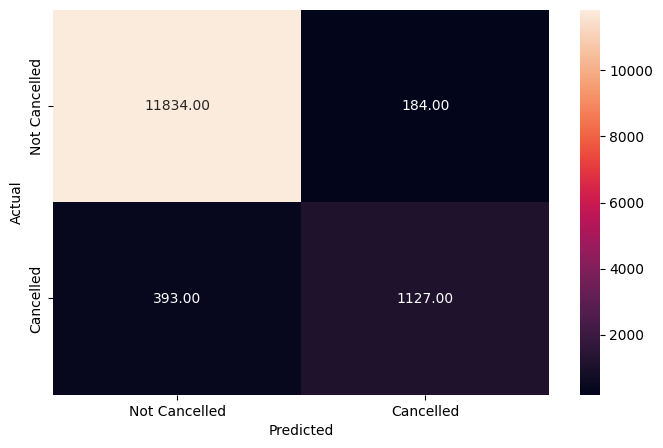

In [20]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))

    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Cancelled', 'Cancelled'], yticklabels=['Not Cancelled', 'Cancelled'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
metrics_score(y_test, y_pred)

Les resultats les plus concluenta sont avec ce modele. Expliquer pourquoi.